Usando dispositivo: cpu


C:\Users\anton\AppData\Local\Temp\ipykernel_23188\3318488023.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Arquitetura do modelo:
LSTMModel(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

Total de parâmetros: 31051
Iniciando treinamento...
Epoch [1/20], Train Loss: 0.094775, Val Loss: 0.129530
Epoch [2/20], Train Loss: 0.032390, Val Loss: 0.015943
Epoch [3/20], Train Loss: 0.006917, Val Loss: 0.005511
Epoch [4/20], Train Loss: 0.003708, Val Loss: 0.006118
Epoch [5/20], Train Loss: 0.003865, Val Loss: 0.004049
Epoch [6/20], Train Loss: 0.003849, Val Loss: 0.006000
Epoch [7/20], Train Loss: 0.003074, Val Loss: 0.004089
Epoch [8/20], Train Loss: 0.002695, Val Loss: 0.004583
Epoch [9/20], Train Loss: 0.002712, Val Loss: 0.004152
Epoch [10/20], Train Loss: 0.002583, Val Loss: 0.004076
Epoch [11/20], Train Loss: 0.002711, Val Loss: 0.003865
Epoch [12/20], Train Loss: 0.002759, Val Loss: 0.003726
Epoch [13/20], Train Loss: 0.002520, Val Loss: 0.004888
Epoch [14/20], Train Los

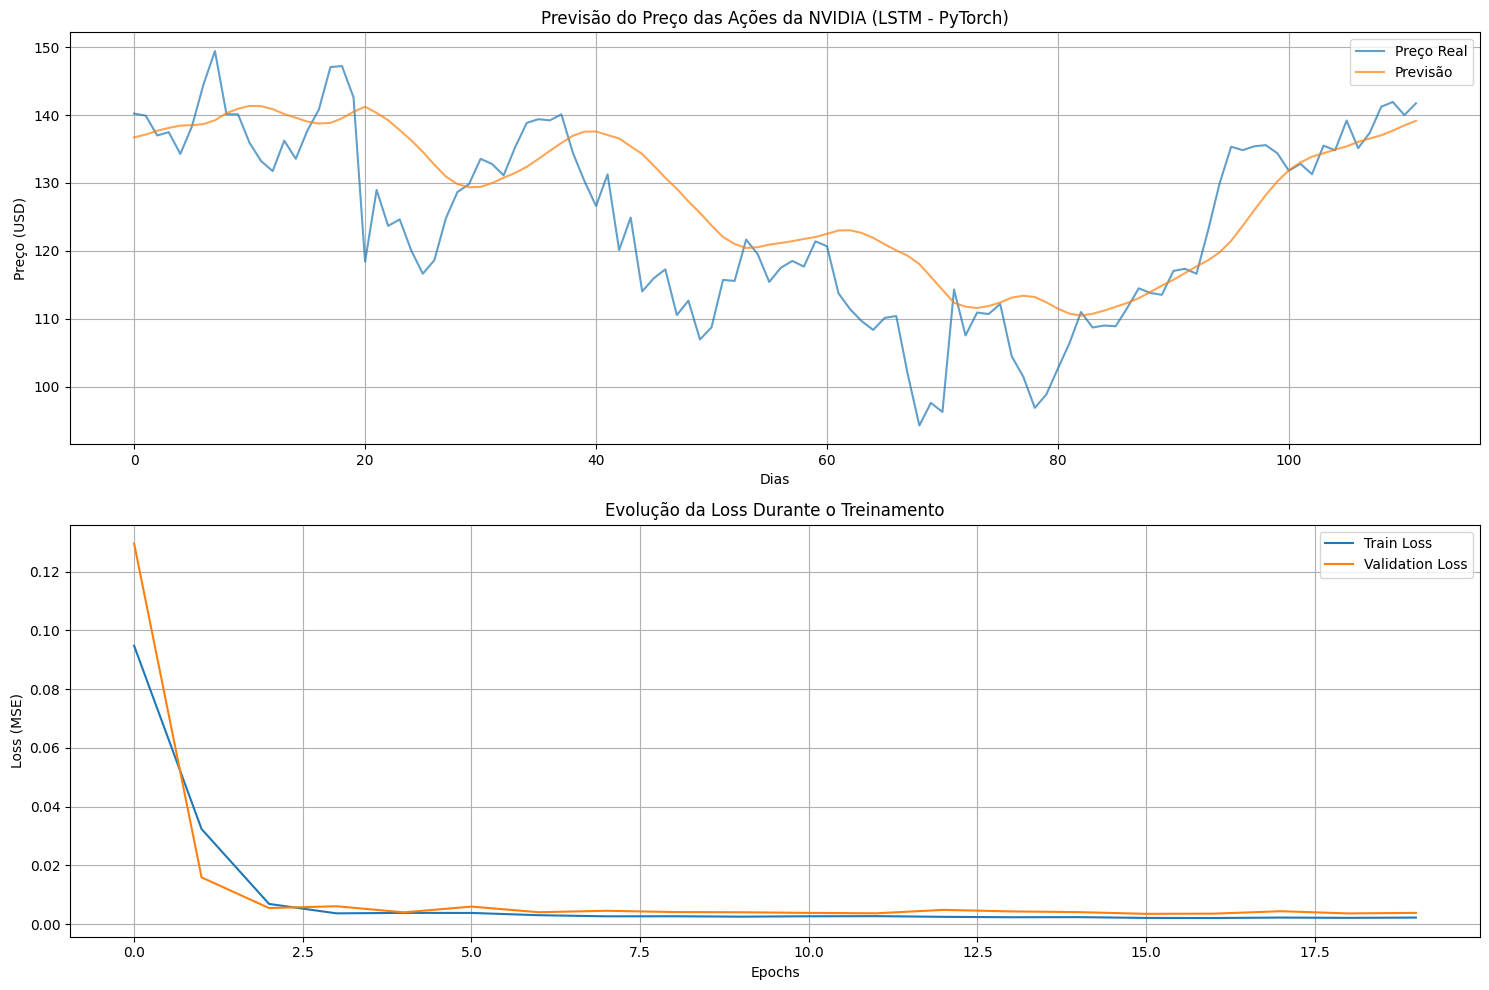


Modelo salvo como 'lstm_model_pytorch.pth'

Para carregar o modelo posteriormente, use:
model, scaler, window_size = load_model_for_inference('lstm_model_pytorch.pth')


In [ ]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datetime import datetime

# Verificar se CUDA está disponível
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")


In [ ]:

# === 1. Coleta dos dados ===
ticker = 'NVDA'
start_date = '2022-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

df = yf.download(ticker, start=start_date, end=end_date)
df = df[['Close']]
df.dropna(inplace=True)


In [ ]:

# === 2. Normalização dos dados ===
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)


In [ ]:

# === 3. Classe Dataset personalizada ===
class StockDataset(Dataset):
    def __init__(self, data, window_size=60):
        self.data = data
        self.window_size = window_size
        
    def __len__(self):
        return len(self.data) - self.window_size
    
    def __getitem__(self, idx):
        x = self.data[idx:idx + self.window_size, 0]
        y = self.data[idx + self.window_size, 0]
        return torch.FloatTensor(x), torch.FloatTensor([y])


In [ ]:

# === 4. Divisão dos dados ===
window_size = 60
split = int(len(scaled_data) * 0.8)  # 80% treino, 20% validação

train_data = scaled_data[:split + window_size]
test_data = scaled_data[split:]

train_dataset = StockDataset(train_data, window_size)
test_dataset = StockDataset(test_data, window_size)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:

# === 5. Definição do modelo LSTM ===
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)
        x = x.unsqueeze(-1)  # Adiciona dimensão de features
        
        # Inicializar estados ocultos
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Usar apenas a última saída temporal
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        
        return out


In [ ]:

# === 6. Instanciar modelo, loss e otimizador ===
model = LSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Arquitetura do modelo:")
print(model)
print(f"\nTotal de parâmetros: {sum(p.numel() for p in model.parameters())}")

# === 7. Função de treinamento ===
def train_model(model, train_loader, test_loader, epochs=20):
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Treinamento
        model.train()
        train_loss = 0.0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validação
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(test_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')
    
    return train_losses, val_losses


In [ ]:

# === 8. Treinamento ===
print("Iniciando treinamento...")
train_losses, val_losses = train_model(model, train_loader, test_loader, epochs=20)


In [ ]:

# === 9. Previsões ===
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        predictions.extend(outputs.cpu().numpy())
        actuals.extend(batch_y.cpu().numpy())

# Converter para numpy arrays
predictions = np.array(predictions).reshape(-1, 1)
actuals = np.array(actuals).reshape(-1, 1)

# Desnormalizar
predictions = scaler.inverse_transform(predictions)
actuals = scaler.inverse_transform(actuals)


In [ ]:

# === 10. Avaliação ===
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
mape = mean_absolute_percentage_error(actuals, predictions)

print(f"\nAvaliação do modelo:")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"MAPE = {mape*100:.2f}%")


In [ ]:

# === 11. Plots ===
# Plot das previsões
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(actuals, label='Preço Real', alpha=0.7)
plt.plot(predictions, label='Previsão', alpha=0.7)
plt.title('Previsão do Preço das Ações da NVIDIA (LSTM - PyTorch)')
plt.xlabel('Dias')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid(True)

# Plot das losses
plt.subplot(2, 1, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Evolução da Loss Durante o Treinamento')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:

# === 12. Salvar o modelo ===
torch.save({
    'model_state_dict': model.state_dict(),
    'scaler': scaler,
    'window_size': window_size,
    'model_params': {
        'input_size': 1,
        'hidden_size': 50,
        'num_layers': 2,
        'dropout': 0.2
    }
}, 'lstm_model_pytorch.pth')

print("\nModelo salvo como 'lstm_model_pytorch.pth'")


In [ ]:

# === 13. Exemplo de como carregar o modelo ===
def load_model_for_inference(model_path):
    checkpoint = torch.load(model_path, map_location=device)
    
    # Recriar modelo
    model = LSTMModel(**checkpoint['model_params']).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    return model, checkpoint['scaler'], checkpoint['window_size']

print("\nPara carregar o modelo posteriormente, use:")
print("model, scaler, window_size = load_model_for_inference('lstm_model_pytorch.pth')")